In [189]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import json
from collections import Counter

from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.svm import LinearSVC
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel

from sklearn.linear_model import LassoCV
from time import time
import warnings
warnings.filterwarnings('ignore')

In [3]:
# dfGb= pd.read_csv("../../our_data/Etap3/dfGB_merged.csv")

# dfUS = pd.read_csv("../../our_data/Etap3/dfUS_merged.csv")

dfGb= pd.read_csv("../../our_data/Etap3/GB_final.csv")

dfUS = pd.read_csv("../../our_data/Etap3/US_final.csv")

In [4]:
dfGb.shape

(3235, 138)

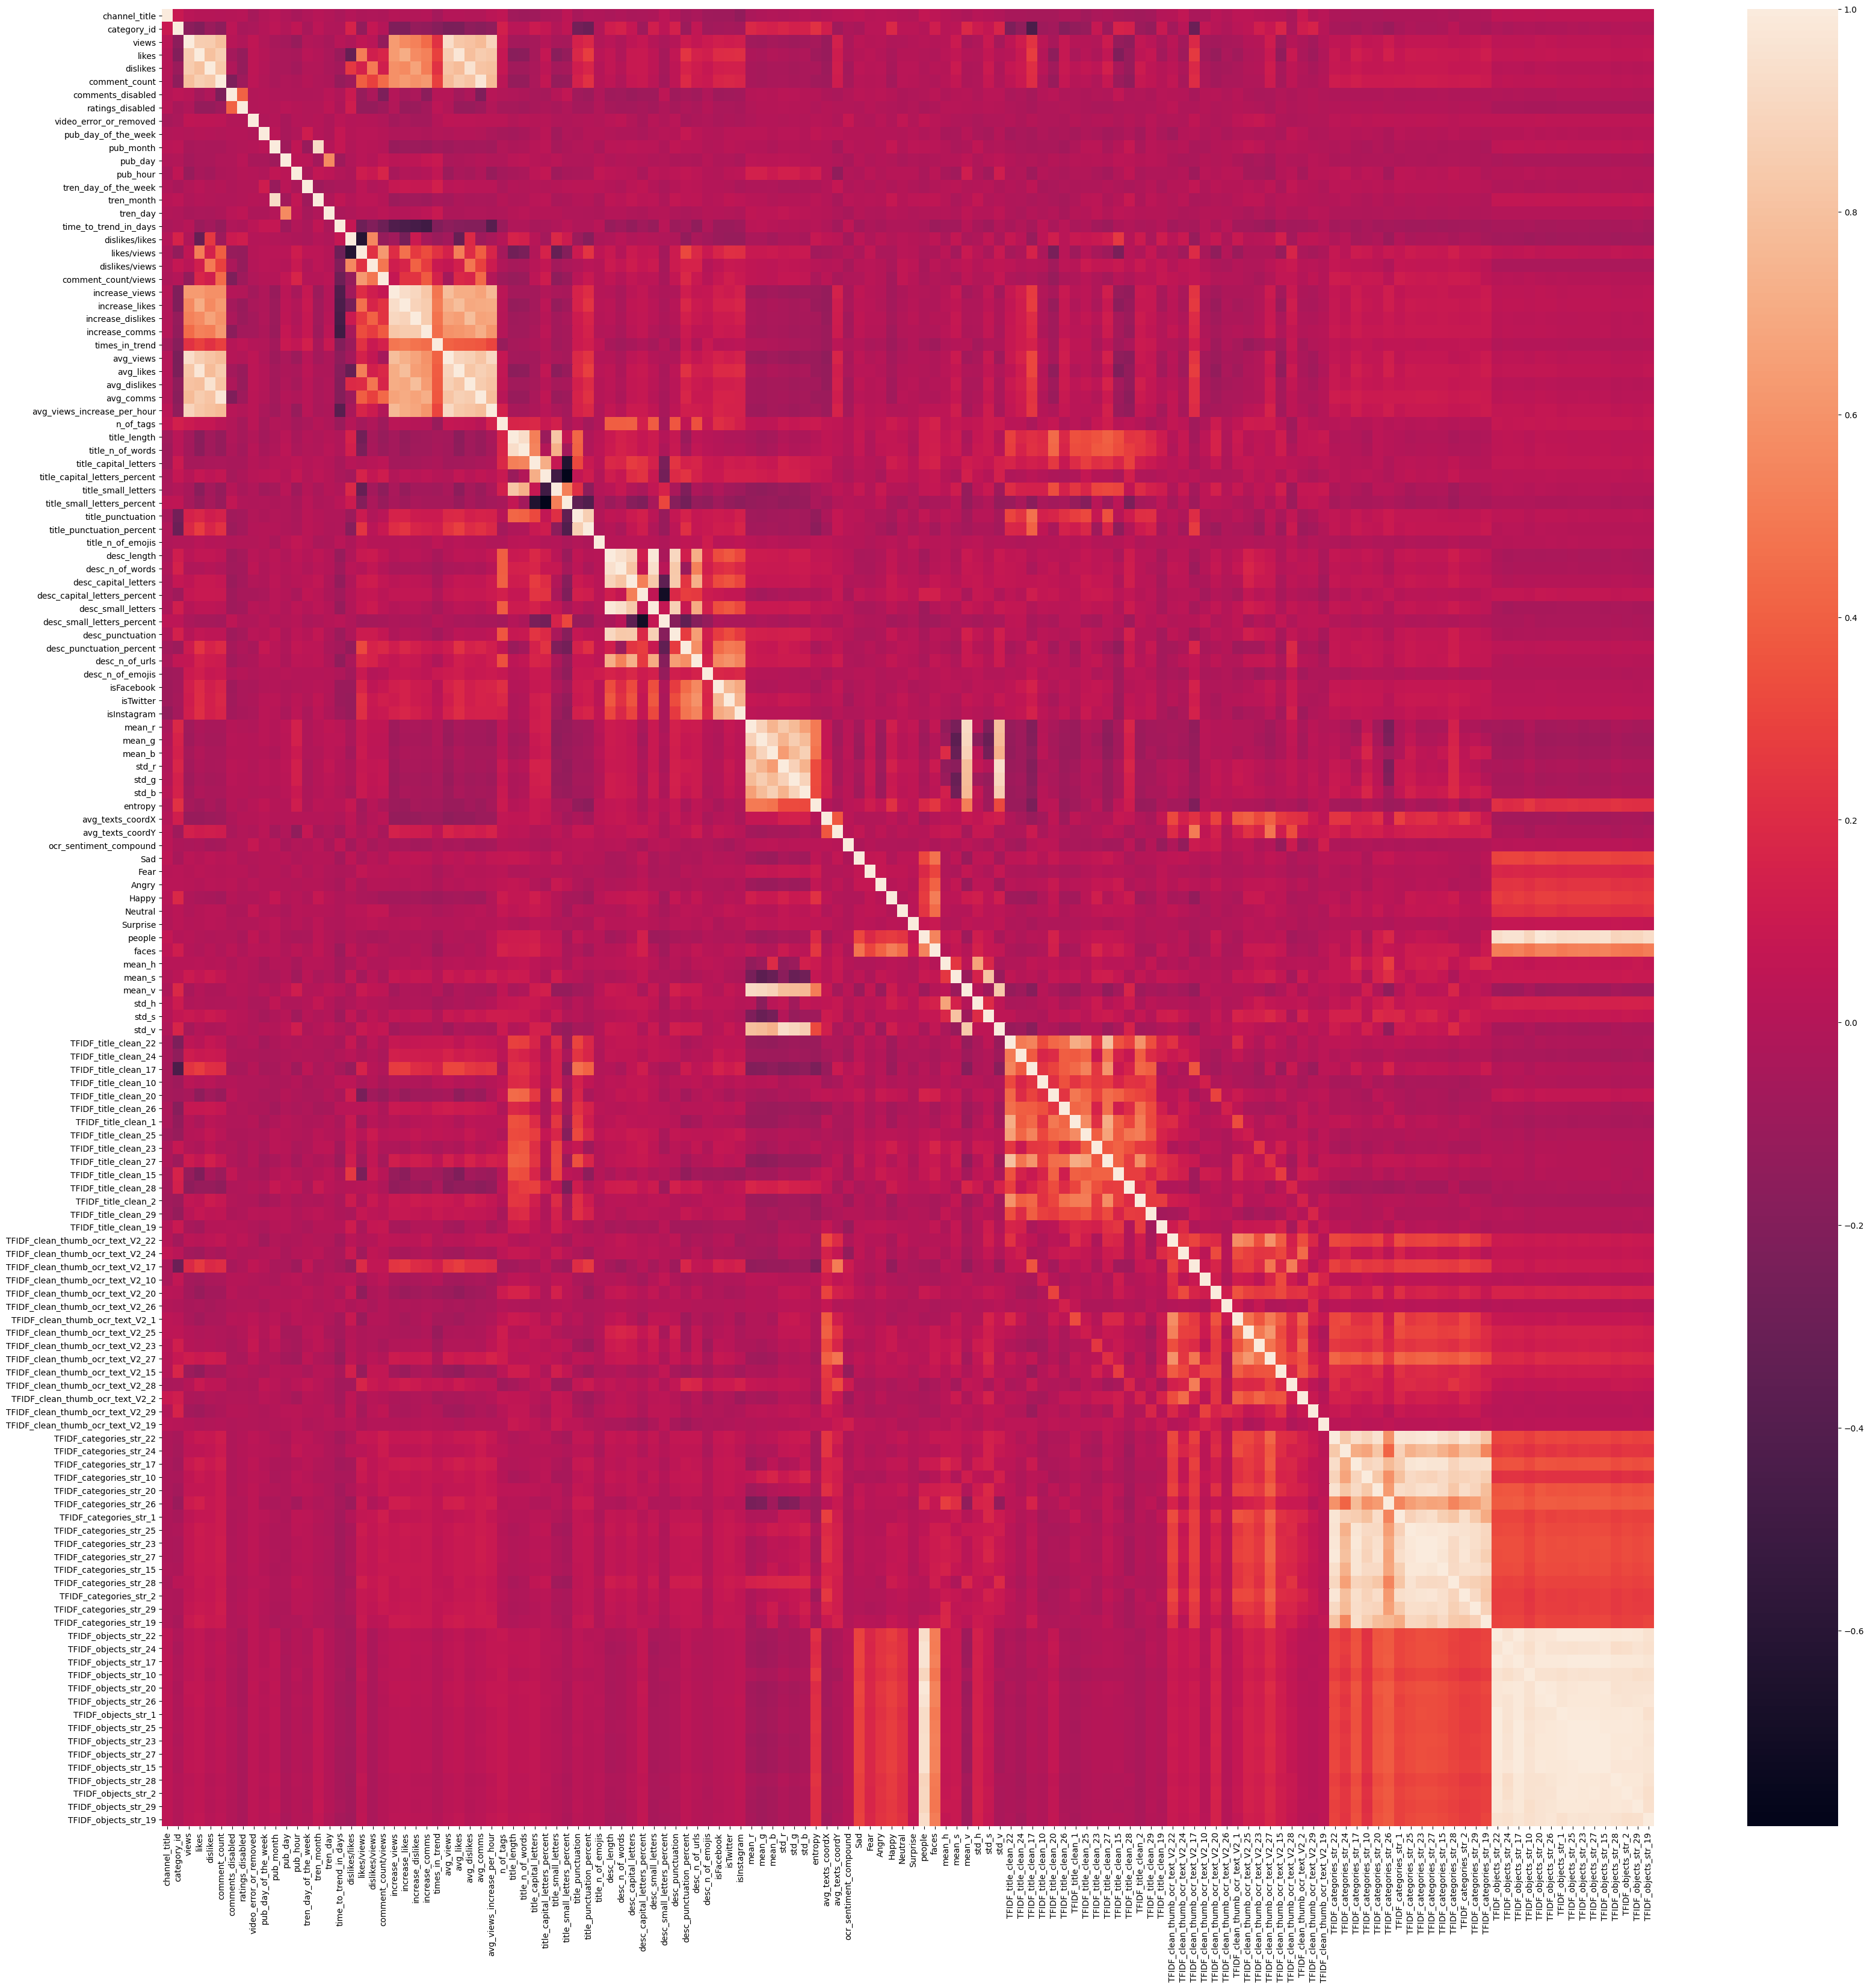

In [139]:
corr = dfGb.corr(method='spearman')
plt.figure(figsize=(40,40),dpi=100)
sns.heatmap(corr)
plt.savefig("../../our_data/Etap3/corr_spearmanGB.pdf")
plt.show()

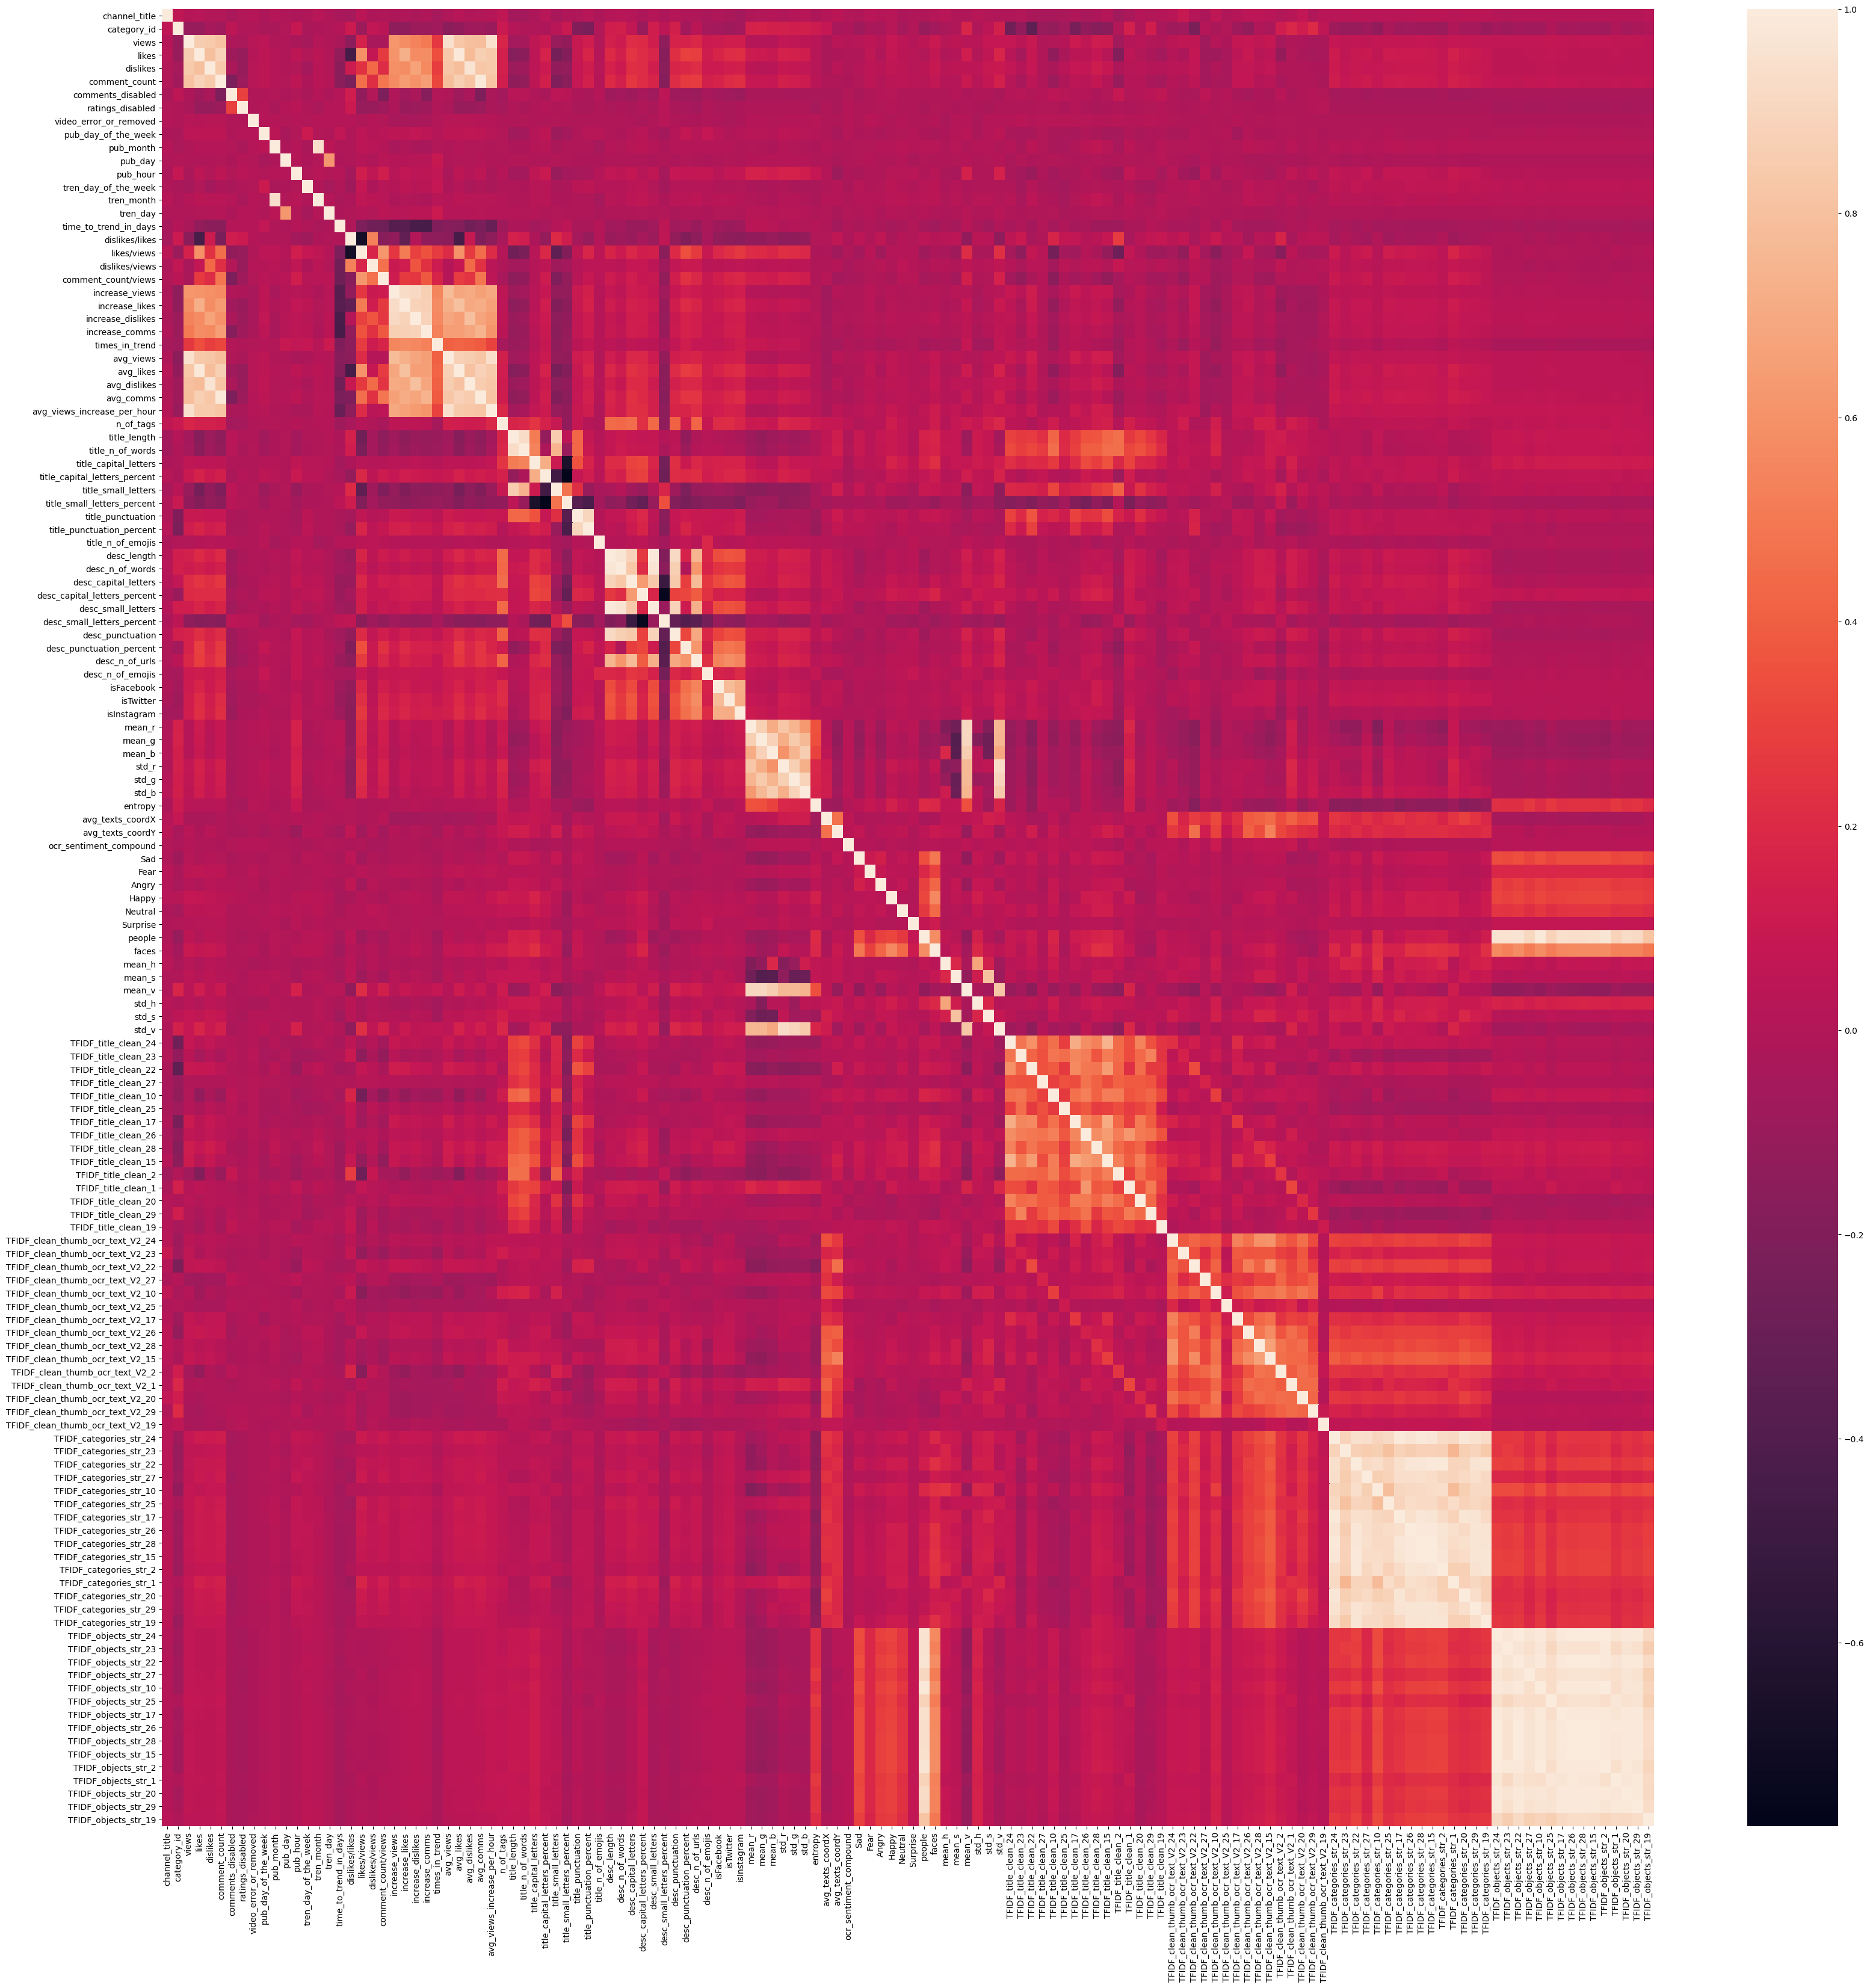

In [140]:
corr = dfUS.corr(method='spearman')
plt.figure(figsize=(40,40),dpi=100)
sns.heatmap(corr)
plt.savefig("../../our_data/Etap3/corr_spearmanUS.pdf")
plt.show()

In [191]:
def prepeareData(df):
    df = df[ df['category_id'].notna() ]
    y = df.loc[:,'category_id']
    X  = df.loc[:, df.columns != 'category_id']
    X = X.select_dtypes(include=np.number)
    X = X.fillna(-1)
    return X, y


def getFI_RForest(X,y,printF= True,plot = True):
    forest = ExtraTreesClassifier(n_estimators=250,
                                  random_state=0)

    forest.fit(X, y)
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]
    df = pd.DataFrame(np.dstack([importances,X.columns])[0])
    if printF: 
        print("Feature ranking:")
        for f in range(X.shape[1]):
            print("%d. feature %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))

    
    if plot:    
        plt.figure(figsize=(10,10))

        plt.title("Feature importances")
        plt.bar(range(X.shape[1]), importances[indices],
                color="r", yerr=std[indices], align="center")
        plt.xticks(range(X.shape[1]), indices)
        plt.xlim([-1, X.shape[1]])
        plt.show()
    
    return df.sort_values(by=0,ascending=False)

def getFI_Bagging(X,y,printF= True,plot = True):
    clf = BaggingClassifier(DecisionTreeClassifier())
    clf.fit(X, y)

    feature_importances = np.mean([
        tree.feature_importances_ for tree in clf.estimators_
    ], axis=0)

    df = pd.DataFrame(np.dstack([feature_importances,X.columns])[0])
    
    indices = np.argsort(feature_importances)[::-1]
    
    if printF: 
        print("Feature ranking:")
        for f in range(X.shape[1]):
            print("%d. feature %s (%f)" % (f + 1, X.columns[indices[f]], feature_importances[indices[f]]))
    if plot:
        
        plt.figure(figsize=(10,10))
            
        plt.title("Feature importances")
        plt.bar(range(X.shape[1]), feature_importances[indices],
                color="r", yerr=std[indices], align="center")
        plt.xticks(range(X.shape[1]), indices)
        plt.xlim([-1, X.shape[1]])
        plt.show()
    return df.sort_values(by=0,ascending=False)

def selectFromModelSVC(X,y,printF= True,plot = True):
    lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X, y)
    model = SelectFromModel(lsvc, prefit=True)
    X_new = model.transform(X)
    feature_idx = model.get_support()
    feature_name = X.columns[feature_idx]    
    if printF:
        print("Before: "+ str(X.shape))
        print("After: "+ str(X_new.shape))        
        print(feature_name)
    return feature_name
        
def getFILasso(X,y,printF= True,plot = True):
    lasso = LassoCV().fit(X, y)
    importance = np.abs(lasso.coef_)
    feature_names = np.array(X.columns)

    df = pd.DataFrame(np.dstack([importance,X.columns])[0])
    
    if printF:
        print(df.sort_values(by=0,ascending=False))

    if plot:
        plt.figure(figsize=(10,10))

        plt.bar(height=importance, x=feature_names)
        plt.title("Feature importances via coefficients")
        plt.show()
    return df.sort_values(by=0,ascending=False)
    
    


In [132]:
dfUS1 = dfUS[dfUS.columns[:78]]
l = list(dfUS.columns[78:])
l.append(dfUS.columns[1])
dfUS2 = dfUS[l]



getFI_RForest(X,y)
Feature ranking:
1. feature likes/views (0.028827)
2. feature channel_title (0.028134)
3. feature n_of_tags (0.022674)
4. feature desc_n_of_urls (0.020733)
5. feature desc_punctuation_percent (0.019667)
6. feature title_punctuation_percent (0.019383)
7. feature title_capital_letters_percent (0.019066)
8. feature title_small_letters_percent (0.018462)
9. feature desc_capital_letters_percent (0.018434)
10. feature desc_n_of_words (0.018348)
11. feature desc_small_letters (0.018276)
12. feature pub_hour (0.018234)
13. feature desc_length (0.018123)
14. feature desc_capital_letters (0.018007)
15. feature avg_texts_coordY (0.018005)
16. feature title_punctuation (0.017843)
17. feature desc_punctuation (0.017757)
18. feature desc_small_letters_percent (0.017667)
19. feature title_capital_letters (0.016879)
20. feature title_small_letters (0.016405)
21. feature title_length (0.016227)
22. feature title_n_of_words (0.015279)
23. feature avg_texts_coordX (0.015098)
24. featu

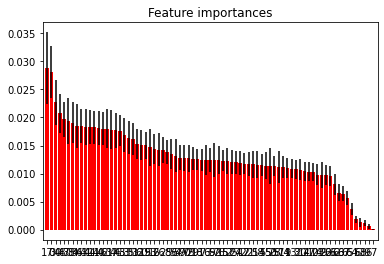


getFILasso(X,y)
              0                            1
28  1.52475e-05                    avg_comms
2   9.89609e-06                        likes
29   1.2404e-06  avg_views_increase_per_hour
20  6.66324e-07               increase_views
25  2.53824e-07                    avg_views
..          ...                          ...
26            0                    avg_likes
24            0               times_in_trend
23            0               increase_comms
22            0            increase_dislikes
76            0                        std_v

[77 rows x 2 columns]


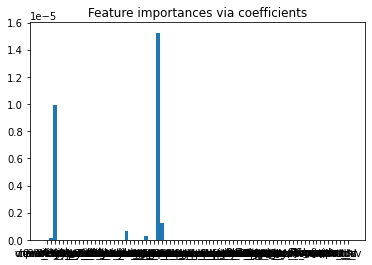


getFI_Bagging(X,y)
Feature ranking:
1. feature channel_title (0.055490)
2. feature likes/views (0.052981)
3. feature avg_texts_coordY (0.039171)
4. feature title_capital_letters_percent (0.035621)
5. feature title_punctuation_percent (0.026764)
6. feature n_of_tags (0.025042)
7. feature desc_capital_letters_percent (0.024898)
8. feature comment_count/views (0.024267)
9. feature pub_hour (0.022718)
10. feature desc_small_letters_percent (0.022159)
11. feature desc_n_of_urls (0.022059)
12. feature desc_punctuation_percent (0.021762)
13. feature desc_punctuation (0.020770)
14. feature dislikes/views (0.020062)
15. feature title_small_letters_percent (0.019406)
16. feature dislikes/likes (0.019128)
17. feature desc_capital_letters (0.018808)
18. feature desc_small_letters (0.018146)
19. feature time_to_trend_in_days (0.017767)
20. feature desc_n_of_words (0.017703)
21. feature entropy (0.016815)
22. feature avg_texts_coordX (0.016756)
23. feature mean_r (0.015770)
24. feature std_s (0.015

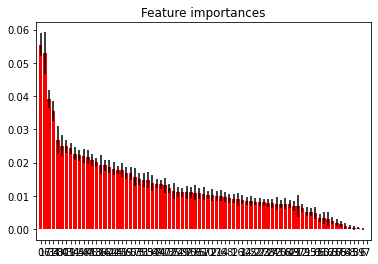


selectFromModelSVC(X,y)
Before: (6283, 77)
After: (6283, 56)
Index(['channel_title', 'likes', 'dislikes', 'comment_count',
       'pub_day_of_the_week', 'pub_month', 'pub_day', 'pub_hour',
       'tren_day_of_the_week', 'tren_month', 'tren_day',
       'time_to_trend_in_days', 'dislikes/likes', 'increase_likes',
       'increase_dislikes', 'increase_comms', 'times_in_trend', 'avg_likes',
       'avg_dislikes', 'avg_comms', 'n_of_tags', 'title_length',
       'title_n_of_words', 'title_capital_letters', 'title_small_letters',
       'title_punctuation', 'desc_length', 'desc_n_of_words',
       'desc_capital_letters', 'desc_small_letters', 'desc_punctuation',
       'desc_n_of_urls', 'desc_n_of_emojis', 'isFacebook', 'isTwitter',
       'isInstagram', 'mean_r', 'mean_g', 'mean_b', 'std_r', 'std_g', 'std_b',
       'entropy', 'avg_texts_coordX', 'avg_texts_coordY',
       'ocr_sentiment_compound', 'Sad', 'Angry', 'Happy', 'Neutral', 'people',
       'faces', 'mean_h', 'mean_s', 'std_s', 

/home/adam/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [133]:
X, y = prepeareData(dfUS1)
print("\ngetFI_RForest(X,y)")
r1 = getFI_RForest(X,y)
print("\ngetFILasso(X,y)")
r2 = getFILasso(X,y)
print("\ngetFI_Bagging(X,y)")
r3 = getFI_Bagging(X,y)
print("\nselectFromModelSVC(X,y)")
r4 = selectFromModelSVC(X,y)
# print("\ngetSelectModel(X,y)")
# getSelectModel(X,y)


getFI_RForest(X,y)
Feature ranking:
1. feature TFIDF_clean_thumb_ocr_text_V2_22 (0.052871)
2. feature TFIDF_title_clean_22 (0.046772)
3. feature TFIDF_title_clean_15 (0.043332)
4. feature TFIDF_title_clean_10 (0.039636)
5. feature TFIDF_title_clean_1 (0.037402)
6. feature TFIDF_title_clean_2 (0.036974)
7. feature TFIDF_clean_thumb_ocr_text_V2_15 (0.034063)
8. feature TFIDF_title_clean_28 (0.031206)
9. feature TFIDF_title_clean_29 (0.030415)
10. feature TFIDF_title_clean_26 (0.027421)
11. feature TFIDF_title_clean_24 (0.027189)
12. feature TFIDF_clean_thumb_ocr_text_V2_2 (0.026122)
13. feature TFIDF_title_clean_20 (0.023741)
14. feature TFIDF_clean_thumb_ocr_text_V2_1 (0.022744)
15. feature TFIDF_title_clean_27 (0.021948)
16. feature TFIDF_clean_thumb_ocr_text_V2_28 (0.021790)
17. feature TFIDF_title_clean_17 (0.021416)
18. feature TFIDF_clean_thumb_ocr_text_V2_10 (0.018235)
19. feature TFIDF_clean_thumb_ocr_text_V2_26 (0.017553)
20. feature TFIDF_title_clean_23 (0.017399)
21. feature 

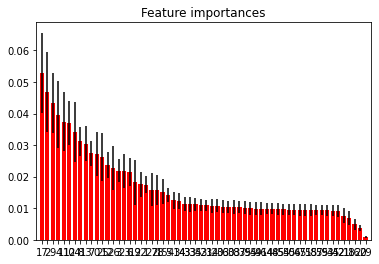


getFILasso(X,y)
            0                                 1
9     17.9849              TFIDF_title_clean_15
0     17.3303              TFIDF_title_clean_24
28    16.2438  TFIDF_clean_thumb_ocr_text_V2_29
16    15.0774  TFIDF_clean_thumb_ocr_text_V2_23
1     14.0104              TFIDF_title_clean_23
13    9.72006              TFIDF_title_clean_29
6     9.26004              TFIDF_title_clean_17
27    8.32041  TFIDF_clean_thumb_ocr_text_V2_20
17    7.56252  TFIDF_clean_thumb_ocr_text_V2_22
3     6.68109              TFIDF_title_clean_27
30    6.33516           TFIDF_categories_str_24
2     6.32208              TFIDF_title_clean_22
32    6.10441           TFIDF_categories_str_22
18    5.96974  TFIDF_clean_thumb_ocr_text_V2_27
29    5.96069  TFIDF_clean_thumb_ocr_text_V2_19
12    5.18118              TFIDF_title_clean_20
15    4.95264  TFIDF_clean_thumb_ocr_text_V2_24
26    4.90936   TFIDF_clean_thumb_ocr_text_V2_1
4     4.80773              TFIDF_title_clean_10
38    4.75749          

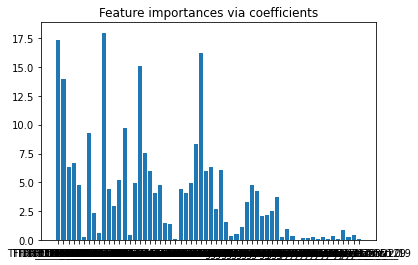


getFI_Bagging(X,y)
Feature ranking:
1. feature TFIDF_clean_thumb_ocr_text_V2_22 (0.072282)
2. feature TFIDF_clean_thumb_ocr_text_V2_15 (0.063223)
3. feature TFIDF_title_clean_10 (0.061200)
4. feature TFIDF_title_clean_15 (0.056436)
5. feature TFIDF_title_clean_22 (0.052071)
6. feature TFIDF_title_clean_1 (0.051573)
7. feature TFIDF_title_clean_28 (0.042888)
8. feature TFIDF_clean_thumb_ocr_text_V2_28 (0.038714)
9. feature TFIDF_title_clean_26 (0.037995)
10. feature TFIDF_title_clean_2 (0.037044)
11. feature TFIDF_clean_thumb_ocr_text_V2_2 (0.034827)
12. feature TFIDF_title_clean_29 (0.032626)
13. feature TFIDF_clean_thumb_ocr_text_V2_1 (0.030803)
14. feature TFIDF_clean_thumb_ocr_text_V2_26 (0.029712)
15. feature TFIDF_clean_thumb_ocr_text_V2_29 (0.028327)
16. feature TFIDF_clean_thumb_ocr_text_V2_20 (0.027439)
17. feature TFIDF_title_clean_27 (0.026176)
18. feature TFIDF_title_clean_24 (0.025394)
19. feature TFIDF_clean_thumb_ocr_text_V2_24 (0.025015)
20. feature TFIDF_title_clean_20

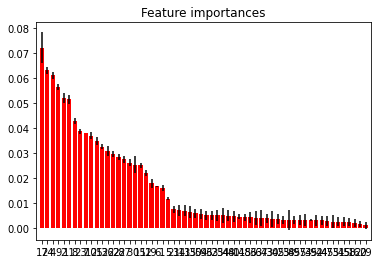


selectFromModelSVC(X,y)
Before: (6283, 60)
After: (6283, 43)
Index(['TFIDF_title_clean_24', 'TFIDF_title_clean_22', 'TFIDF_title_clean_27',
       'TFIDF_title_clean_10', 'TFIDF_title_clean_25', 'TFIDF_title_clean_17',
       'TFIDF_title_clean_26', 'TFIDF_title_clean_28', 'TFIDF_title_clean_15',
       'TFIDF_title_clean_2', 'TFIDF_title_clean_1', 'TFIDF_title_clean_29',
       'TFIDF_clean_thumb_ocr_text_V2_24', 'TFIDF_clean_thumb_ocr_text_V2_22',
       'TFIDF_clean_thumb_ocr_text_V2_26', 'TFIDF_clean_thumb_ocr_text_V2_28',
       'TFIDF_clean_thumb_ocr_text_V2_15', 'TFIDF_clean_thumb_ocr_text_V2_2',
       'TFIDF_clean_thumb_ocr_text_V2_20', 'TFIDF_categories_str_24',
       'TFIDF_categories_str_23', 'TFIDF_categories_str_22',
       'TFIDF_categories_str_10', 'TFIDF_categories_str_17',
       'TFIDF_categories_str_26', 'TFIDF_categories_str_28',
       'TFIDF_categories_str_15', 'TFIDF_categories_str_2',
       'TFIDF_categories_str_1', 'TFIDF_categories_str_20',
       'TFIDF_o

In [154]:
X, y = prepeareData(dfUS2)
print("\ngetFI_RForest(X,y)")
g1 = getFI_RForest(X,y)
print("\ngetFILasso(X,y)")
g2 = getFILasso(X,y)
print("\ngetFI_Bagging(X,y)")
g3 = getFI_Bagging(X,y)
print("\nselectFromModelSVC(X,y)")
g4 = selectFromModelSVC(X,y)
# print("\ngetSelectModel(X,y)")
# getSelectModel(X,y)


getFI_RForest(X,y)
Feature ranking:
1. feature TFIDF_clean_thumb_ocr_text_V2_22 (0.036853)
2. feature TFIDF_title_clean_22 (0.025015)
3. feature TFIDF_title_clean_10 (0.022016)
4. feature TFIDF_title_clean_15 (0.020061)
5. feature TFIDF_clean_thumb_ocr_text_V2_15 (0.019608)
6. feature TFIDF_title_clean_1 (0.018807)
7. feature TFIDF_title_clean_2 (0.018587)
8. feature TFIDF_clean_thumb_ocr_text_V2_2 (0.017054)
9. feature TFIDF_title_clean_29 (0.015724)
10. feature likes/views (0.015337)
11. feature TFIDF_title_clean_24 (0.014451)
12. feature TFIDF_title_clean_28 (0.014079)
13. feature TFIDF_clean_thumb_ocr_text_V2_1 (0.013277)
14. feature TFIDF_clean_thumb_ocr_text_V2_28 (0.012498)
15. feature channel_title (0.012083)
16. feature TFIDF_title_clean_26 (0.012024)
17. feature TFIDF_clean_thumb_ocr_text_V2_10 (0.011877)
18. feature TFIDF_title_clean_20 (0.011262)
19. feature TFIDF_title_clean_27 (0.011120)
20. feature n_of_tags (0.010275)
21. feature TFIDF_title_clean_17 (0.010095)
22. fea

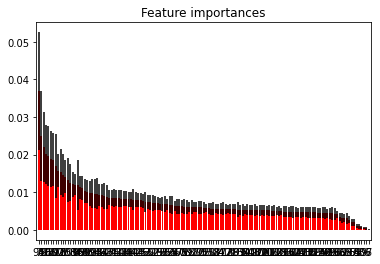


getFILasso(X,y)
               0                             1
28   1.52475e-05                     avg_comms
2    9.89609e-06                         likes
29    1.2404e-06   avg_views_increase_per_hour
20   6.66324e-07                increase_views
25   2.53824e-07                     avg_views
..           ...                           ...
43             0  desc_capital_letters_percent
42             0          desc_capital_letters
41             0               desc_n_of_words
40             0                   desc_length
136            0          TFIDF_objects_str_19

[137 rows x 2 columns]


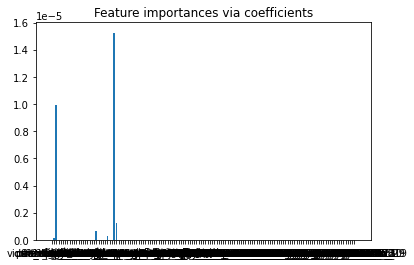


getFI_Bagging(X,y)
Feature ranking:
1. feature TFIDF_clean_thumb_ocr_text_V2_22 (0.066067)
2. feature TFIDF_title_clean_10 (0.051741)
3. feature TFIDF_title_clean_15 (0.050489)
4. feature TFIDF_title_clean_1 (0.050262)
5. feature TFIDF_clean_thumb_ocr_text_V2_15 (0.048664)
6. feature TFIDF_title_clean_22 (0.043815)
7. feature TFIDF_title_clean_28 (0.035321)
8. feature TFIDF_title_clean_2 (0.033418)
9. feature TFIDF_title_clean_29 (0.032248)
10. feature TFIDF_clean_thumb_ocr_text_V2_28 (0.029162)
11. feature TFIDF_title_clean_26 (0.027660)
12. feature TFIDF_clean_thumb_ocr_text_V2_2 (0.026146)
13. feature TFIDF_clean_thumb_ocr_text_V2_26 (0.023596)
14. feature TFIDF_clean_thumb_ocr_text_V2_24 (0.021523)
15. feature TFIDF_clean_thumb_ocr_text_V2_20 (0.020937)
16. feature TFIDF_title_clean_27 (0.018978)
17. feature TFIDF_clean_thumb_ocr_text_V2_29 (0.018467)
18. feature TFIDF_title_clean_20 (0.017838)
19. feature TFIDF_clean_thumb_ocr_text_V2_1 (0.017663)
20. feature TFIDF_title_clean_24

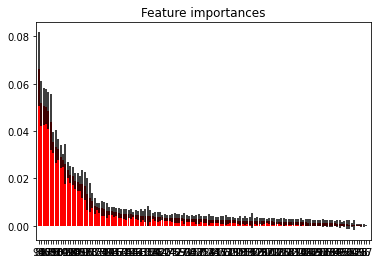


selectFromModelSVC(X,y)
Before: (6283, 137)
After: (6283, 96)
Index(['channel_title', 'likes', 'dislikes', 'comment_count',
       'pub_day_of_the_week', 'pub_month', 'pub_day', 'pub_hour',
       'tren_day_of_the_week', 'tren_month', 'tren_day',
       'time_to_trend_in_days', 'dislikes/likes', 'increase_likes',
       'increase_dislikes', 'increase_comms', 'times_in_trend', 'avg_likes',
       'avg_dislikes', 'avg_comms', 'n_of_tags', 'title_length',
       'title_n_of_words', 'title_capital_letters', 'title_small_letters',
       'title_punctuation', 'desc_length', 'desc_n_of_words',
       'desc_capital_letters', 'desc_small_letters', 'desc_punctuation',
       'desc_n_of_urls', 'desc_n_of_emojis', 'isFacebook', 'isTwitter',
       'isInstagram', 'mean_r', 'mean_g', 'mean_b', 'std_r', 'std_g', 'std_b',
       'entropy', 'avg_texts_coordX', 'avg_texts_coordY', 'Sad', 'Fear',
       'Angry', 'Happy', 'Neutral', 'people', 'faces', 'mean_h', 'mean_s',
       'std_s', 'TFIDF_title_clea

/home/adam/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [136]:
X, y = prepeareData(dfUS)
print("\ngetFI_RForest(X,y)")
r1 = getFI_RForest(X,y)
print("\ngetFILasso(X,y)")
r2 = getFILasso(X,y)
print("\ngetFI_Bagging(X,y)")
r3 = getFI_Bagging(X,y)
print("\nselectFromModelSVC(X,y)")
r4 = selectFromModelSVC(X,y)
# print("\ngetSelectModel(X,y)")
# getSelectModel(X,y)

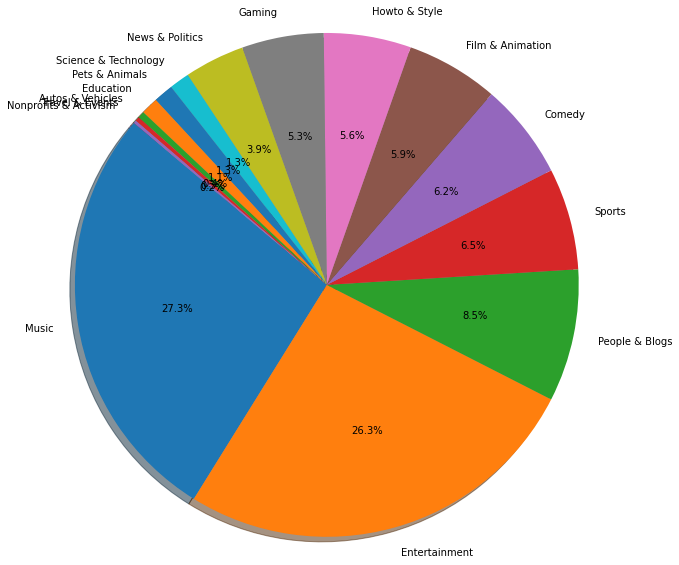

In [188]:
with open("./../../data/youtube_data/US_category_id.json") as file:
    data = json.loads(file.read())
    
US_cats = {}
for item in data['items']:
    US_cats[item['id']] = item['snippet']['title']



gbCtr = Counter(dfGb.loc[:, "category_id"]).most_common()
gbCatdata = []
gbCatlabels = []
for c in gbCtr:
    try:
        gbCatlabels.append(US_cats[str(int(c[0]))])
        gbCatdata.append(c[1])
    except:
        print("error")


plt.figure(figsize=(10,10))
plt.pie(gbCatdata, labels=gbCatlabels ,autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()


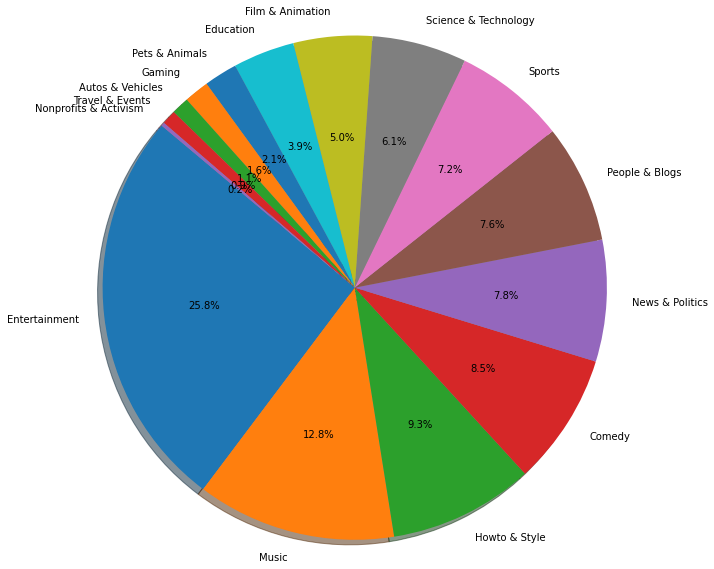

In [187]:
usCtr = Counter(dfUS.loc[:, "category_id"]).most_common()
usCatdata = []
usCatlabels = []
for c in usCtr:
    try:
        usCatlabels.append(US_cats[str(int(c[0]))])

        usCatdata.append(c[1])
    except:
         print("error")

# Plot
plt.figure(figsize=(10,10))
plt.pie(usCatdata, labels=usCatlabels ,autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()
